In [2]:
print("Python běží!")

Python běží!


In [3]:
import sys

sys.path.append('../')
sys.path.append('../my_libs/')
sys.path.append('../my_libs/img/')

!{sys.executable} -m pip install -r ../../pip-dependencies.txt

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import my_libs as ml
from my_libs.tools import *
from my_libs.fft import *
from my_libs.colors import *
from my_libs.img.processing import *
from my_libs.img.box_coords import *

In [5]:
ml.tools.printf("Hello world!")

Hello world!

In [6]:
import skimage.feature

# Cvičení 8: slunečnice

Vytvořte  základní detektor  slunečnicových  květů  pomocí operace Laplacián  Gaussiánu  a  vyhodnoťte  jeho  úspěšnost  metrikami  precision  a recall. 

### Postup:
- Detekujte  tmavé  bloby  na  světlém  pozadí  pomocí  operace  **Laplacián Gaussiánu**. 
- Okolo  každého  blobu  vyřízněte  čtvercovou  oblast  o straně  přibližně `4*sigma.` 
- Oblast  převeďte  do  barevného  prostoru  HSV/HSL/...  a  ze  složky  hue vypočtěte histogram. 
- Porovnejte  histogram  se  shodně  připraveným  histogramem  vzorového obrázku `pvi_cv08_sunflower_template.jpg` pomocí Kullback-Lieblerovy divergence.  Pokud se ve vypočtených divergencích objeví  NaN,  přičtěte do porovnávaných histogramů malé číslo, např. 0.001,  aby  nedocházelo k logaritmování nebo dělení nulou. 
- Vhodně  stanoveným  prahem  divergence filtrujte oblasti, které nejsou slunečnicové květy. 
- Opakujte postup pro obrázky se slunečnicemi v archivu pvi_cv08.zip 
- Podobně  jako  ve  cvičení  č.  7  vypočtěte  hodnoty  **precision**  a  **recall**  při IoU=0.5. 
 
### Zdroje:
- [scikit-image](https://scikit-image.org/docs/stable/index.html)
  - [feature](https://scikit-image.org/docs/stable/api/skimage.feature.html) 
  - [peak_local_max](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.peak_local_max)
- [scipy](https://docs.scipy.org/doc/scipy/reference/index.html)
  - [kl_div](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html)
  - [entropy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) 

In [7]:
folder = 'data/'
IoU=0.5
#a = 4*sigma
sunflower_template_file = "pvi_cv08_sunflower_template.jpg"

## Načtení souborů

In [8]:
from my_libs.img import images
# reload img module
import importlib
importlib.reload(images)

# Find files
files = images.find(folder, "txt")  
files.sort()

# Filter images
picture_files = images.find(folder, "jpg")
picture_files.sort()

# remove template file
for i in range(len(picture_files)):
    if picture_files[i].find(sunflower_template_file) != -1:
        picture_files.pop(i)
        break

number_of_images = len(picture_files)
print("Number of images: ", number_of_images)


# Load images
imgs = images.load(picture_files)

Current working directory: /home/pytel/Skola/TUL-navazující_studium/3. semestr/PVI-Pocitacove_videni/cviceni/cv08, files: 
pvi_cv08_sunflowers4.txt
pvi_cv08_sunflowers1.txt
pvi_cv08_sunflowers2.txt
pvi_cv08_sunflowers3.txt
Current working directory: /home/pytel/Skola/TUL-navazující_studium/3. semestr/PVI-Pocitacove_videni/cviceni/cv08, files: 
pvi_cv08_sunflowers2.jpg
pvi_cv08_sunflowers3.jpg
pvi_cv08_sunflowers4.jpg
pvi_cv08_sunflower_template.jpg
pvi_cv08_sunflowers1.jpg
Number of images:  4


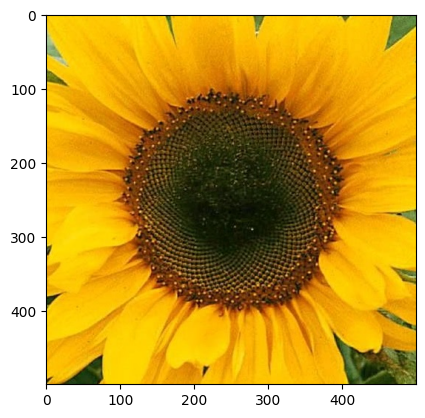

In [9]:
# nacteni textovych souboru
dict_files_boxes = load_files_to_dict(files)

# Load template
img_template_bgr = cv2.imread(folder + sunflower_template_file)
img_template = cv2.cvtColor(img_template_bgr, cv2.COLOR_BGR2RGB)


# visualize template
plt.imshow(img_template)

## Detekujte  tmavé  bloby  na  světlém  pozadí  pomocí  operace  Laplacián Gaussiánu.

In [10]:
def genereta_sizes(min, max):
    """ 
    sigma_k = sigma_0 * s^k 
    s = sqrt(2)
    """
    # use yeald
    s = np.sqrt(2)
    sigma_0 = min
    sigma_k = sigma_0
    while sigma_k < max:
        yield sigma_k
        sigma_k *= s

# test
sigma_min = 1
sigma_max = 50
sizes = list(genereta_sizes(sigma_min, sigma_max))

for i in range(len(sizes)):
    sizes[i] = float(round(sizes[i], 2))

print(sizes)

[1.0, 1.41, 2.0, 2.83, 4.0, 5.66, 8.0, 11.31, 16.0, 22.63, 32.0, 45.25]


2.0
2.83
4.0
5.66
8.0
11.31
16.0
22.63
32.0
45.25
64.0
90.51


/tmp/ipykernel_9377/1146756611.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

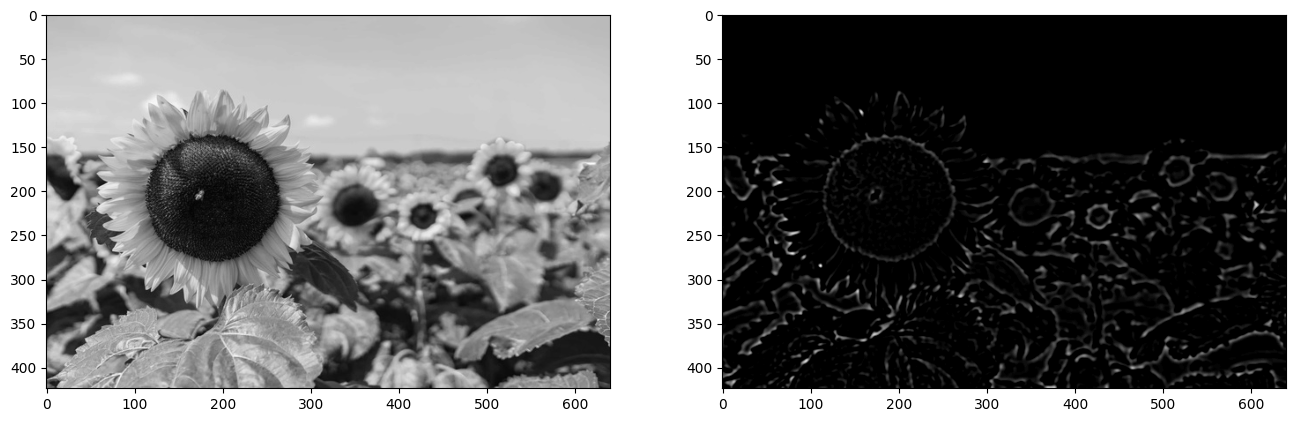

<Figure size 640x480 with 0 Axes>

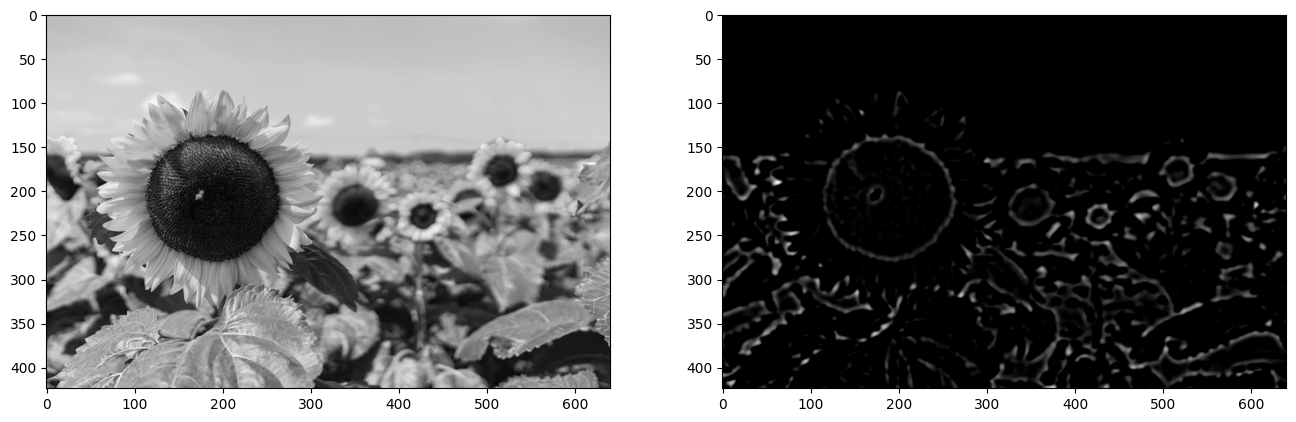

<Figure size 640x480 with 0 Axes>

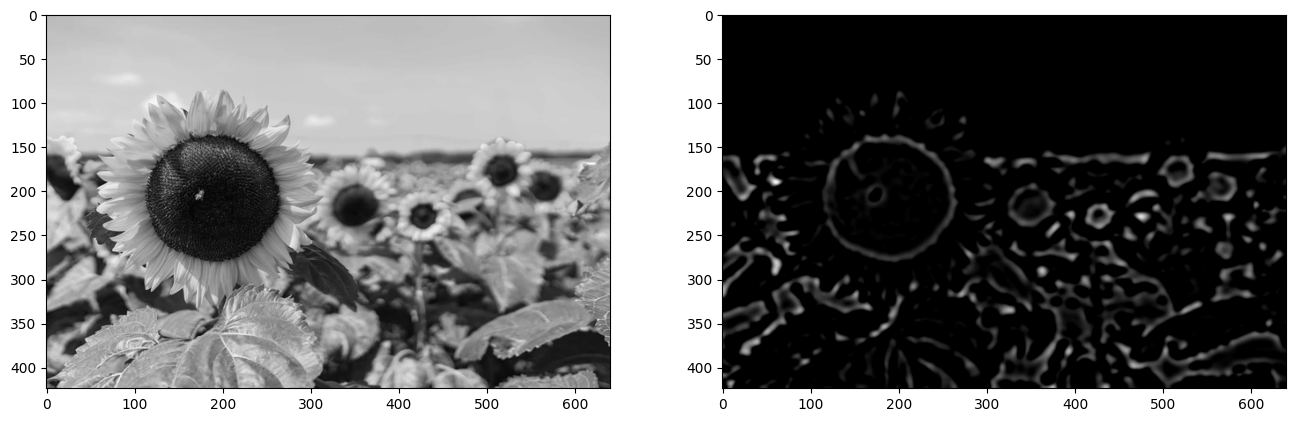

<Figure size 640x480 with 0 Axes>

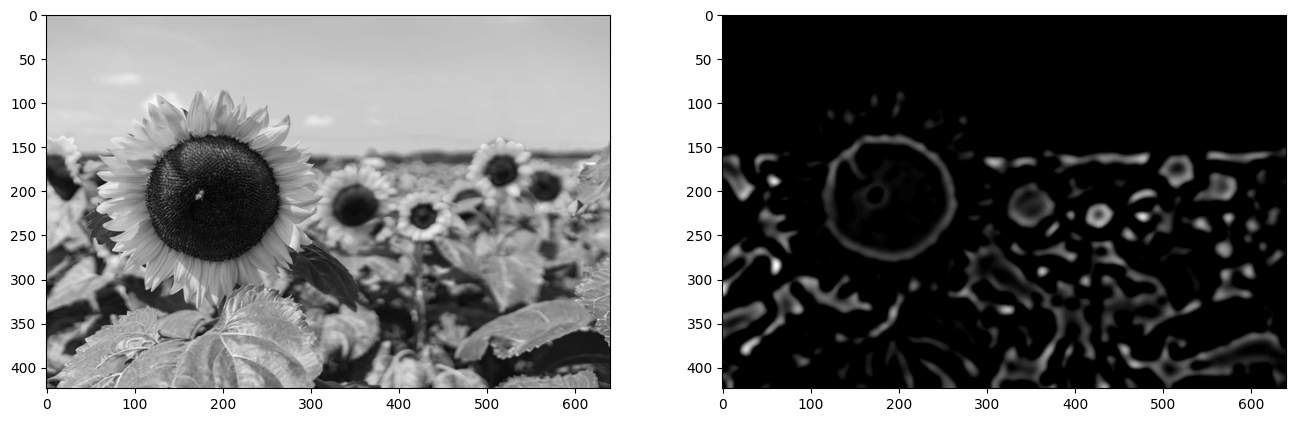

<Figure size 640x480 with 0 Axes>

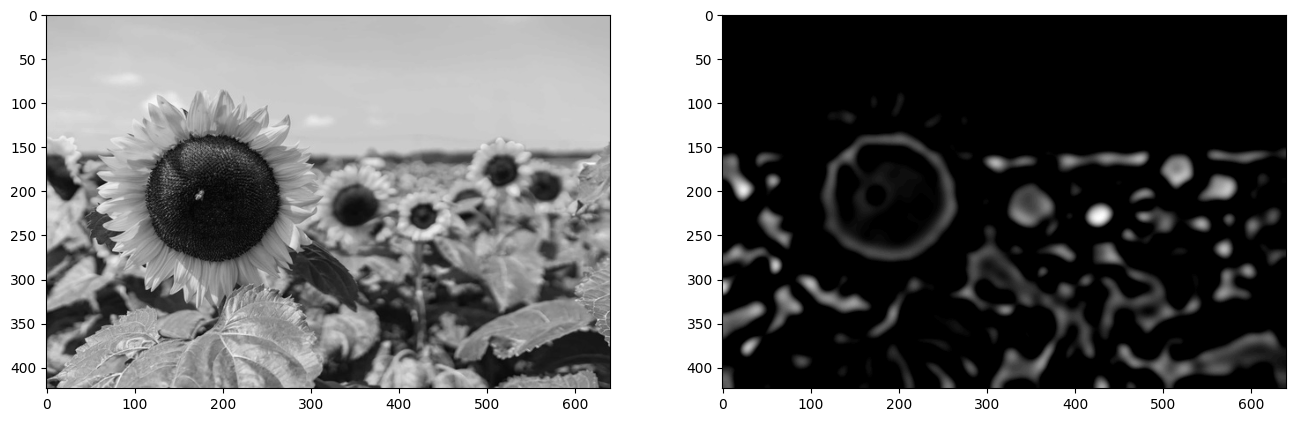

<Figure size 640x480 with 0 Axes>

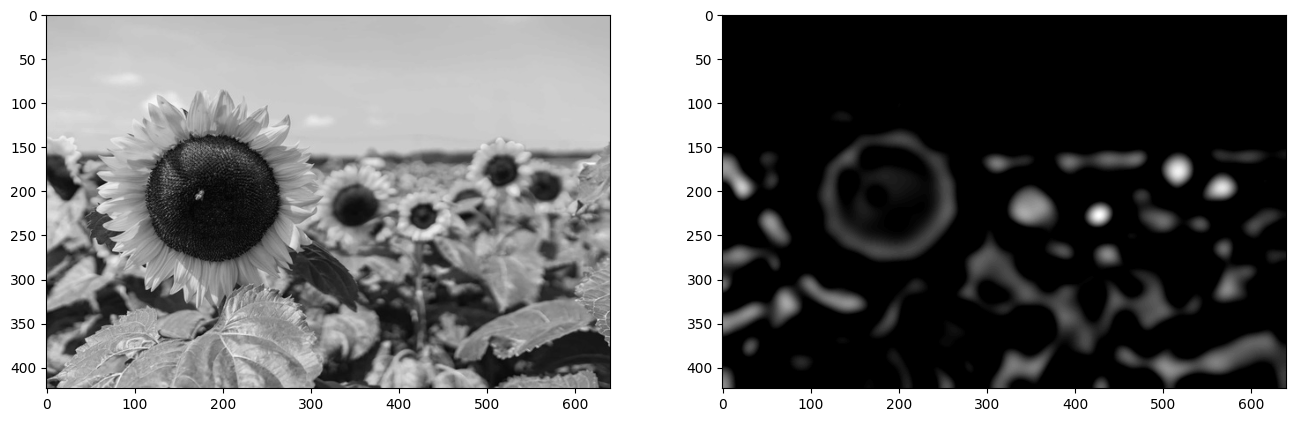

<Figure size 640x480 with 0 Axes>

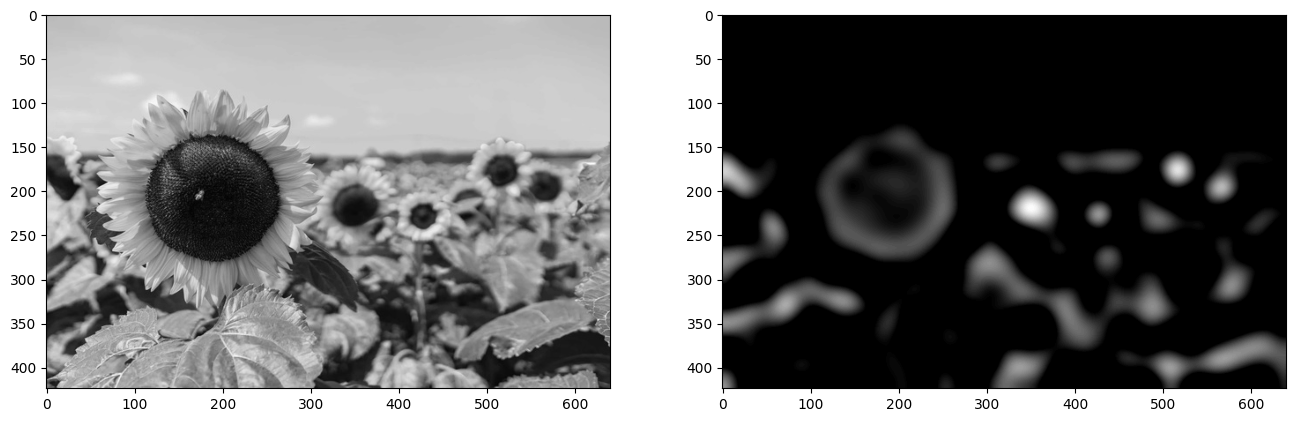

<Figure size 640x480 with 0 Axes>

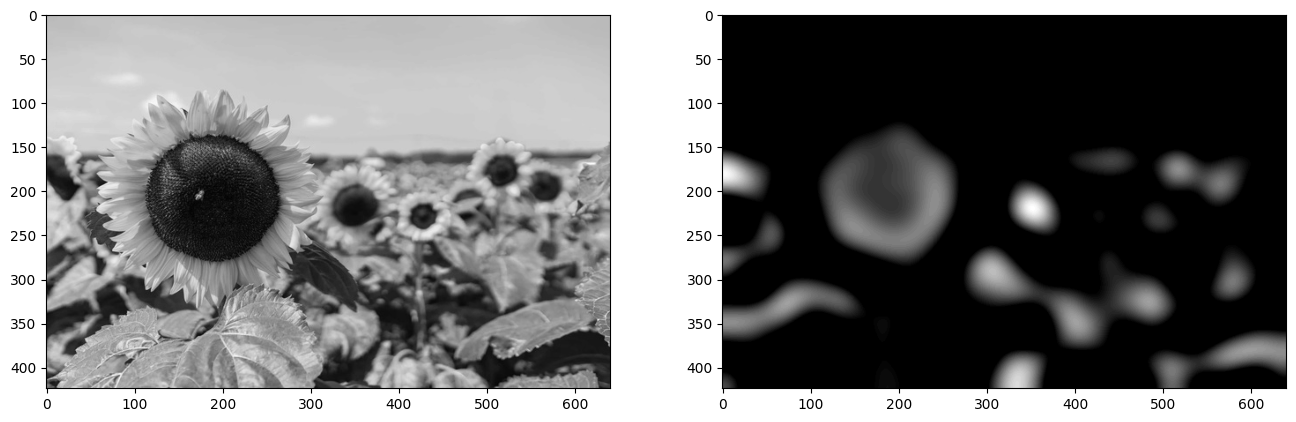

<Figure size 640x480 with 0 Axes>

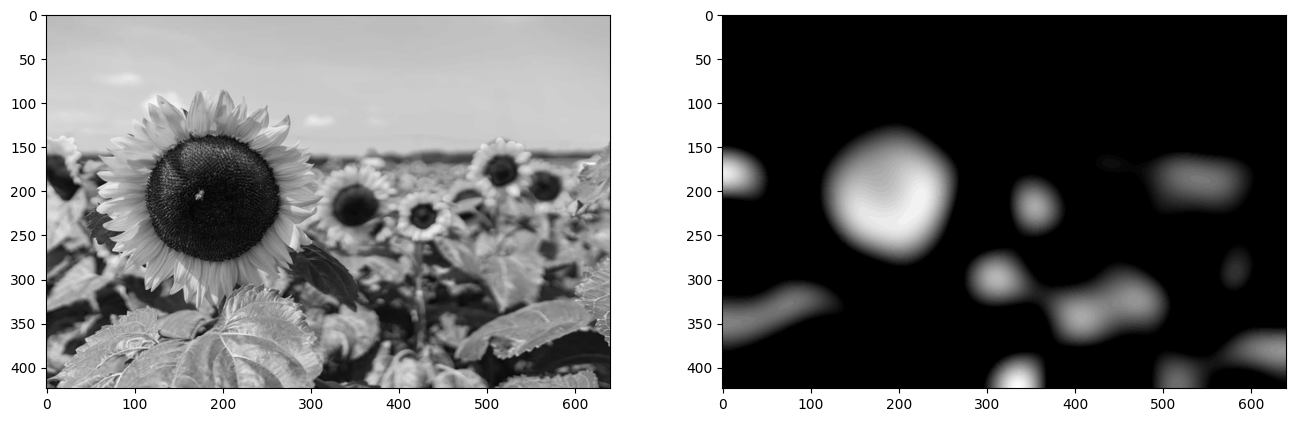

<Figure size 640x480 with 0 Axes>

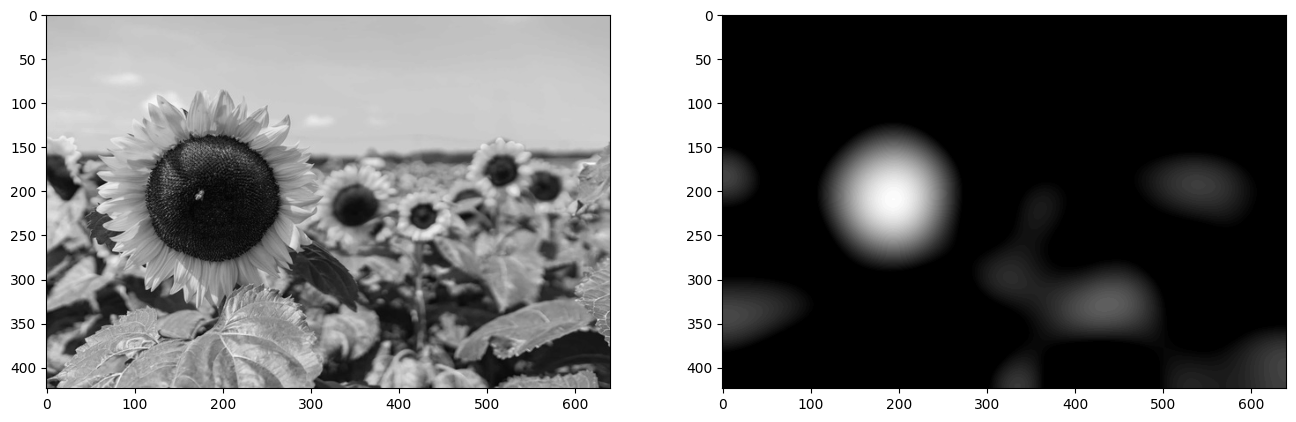

<Figure size 640x480 with 0 Axes>

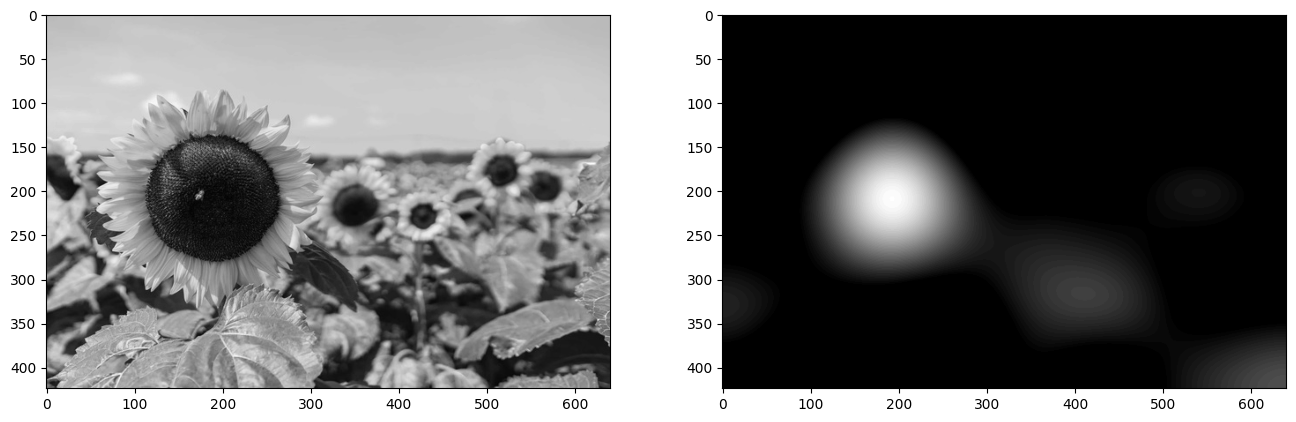

<Figure size 640x480 with 0 Axes>

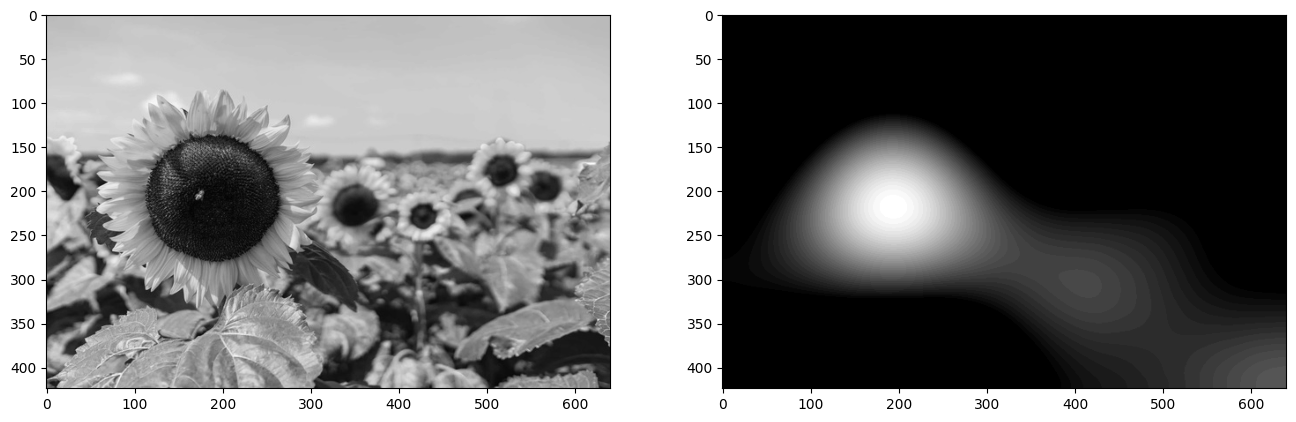

In [11]:
# Detekujte  tmavé  bloby  na  světlém  pozadí  pomocí  operace  Laplacián Gaussiánu

def LoG_filter(image, sigma, size=None):
    """
    Apply Laplacian of Gaussian filter to an image.

    Zdroj:
    - https://medium.com/@rajilini/laplacian-of-gaussian-filter-log-for-image-processing-c2d1659d5d2
    
    Parameters:
        image (ndarray): Input image.
        sigma (float): Standard deviation for Gaussian kernel.
        size (int, optional): Size of the Gaussian kernel. If None, it will be calculated.
        
    Returns:
        ndarray: Image after applying LoG filter.
    """
    # Generate LoG kernel
    if size is None:
        size = int(6 * sigma + 1) if sigma >= 1 else 7

    if size % 2 == 0:
        size += 1

    x, y = np.meshgrid(np.arange(-size//2+1, size//2+1), np.arange(-size//2+1, size//2+1))
    kernel = -(1/(np.pi * sigma**4)) * (1 - ((x**2 + y**2) / (2 * sigma**2))) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / np.sum(np.abs(kernel))

    # Perform convolution using OpenCV filter2D
    result = cv2.filter2D(image, -1, kernel)

    return result

# test
image = imgs[0]
sigma_min = 2
sigma_max = int(min(image.shape[0], image.shape[1])/4)
for sigma in genereta_sizes(sigma_min, sigma_max):
    sigma = float(round(sigma, 2))
    print(sigma)
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_template_log = LoG_filter(img_gray, sigma)

    # visualize
    plt.figure()
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img_gray, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(img_template_log, cmap='gray')

## Rozpoznání blobů

60


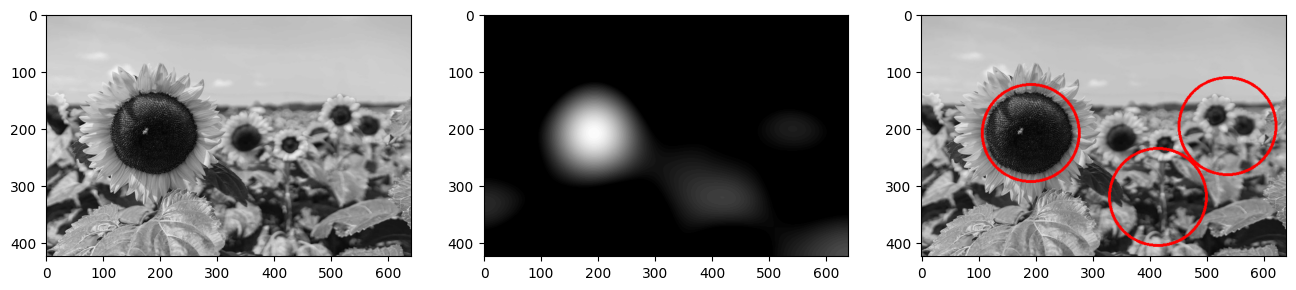

In [12]:
sigma = 60
num_peaks = 100
print(sigma)

# Apply LoG filter
img_gray = cv2.cvtColor(imgs[0], cv2.COLOR_RGB2GRAY)
img_log = LoG_filter(img_gray, sigma)

# Find local maxima
min_distance = int(sigma)
maxima = skimage.feature.peak_local_max(img_log, min_distance=min_distance, threshold_abs=0.01, num_peaks=num_peaks)

def sigma_to_radius(sigma):
    radius = int(np.round(sigma * np.sqrt(2)))
    return radius

# Create list of blobs
blobs = []
for y, x in maxima:
    blobs.append((x, y, sigma))

# Draw blobs
img_blobs = img_gray.copy()
# to color
img_blobs = cv2.cvtColor(img_blobs, cv2.COLOR_GRAY2RGB)
color = (255, 0, 0)
size = 3
for x, y, sigma in blobs:
    r = sigma_to_radius(sigma)
    cv2.circle(img_blobs, (x, y), r, color, size)

# visualize
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(img_log, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(img_blobs)
plt.show()

## Převod do HSV a výpočet histogramu

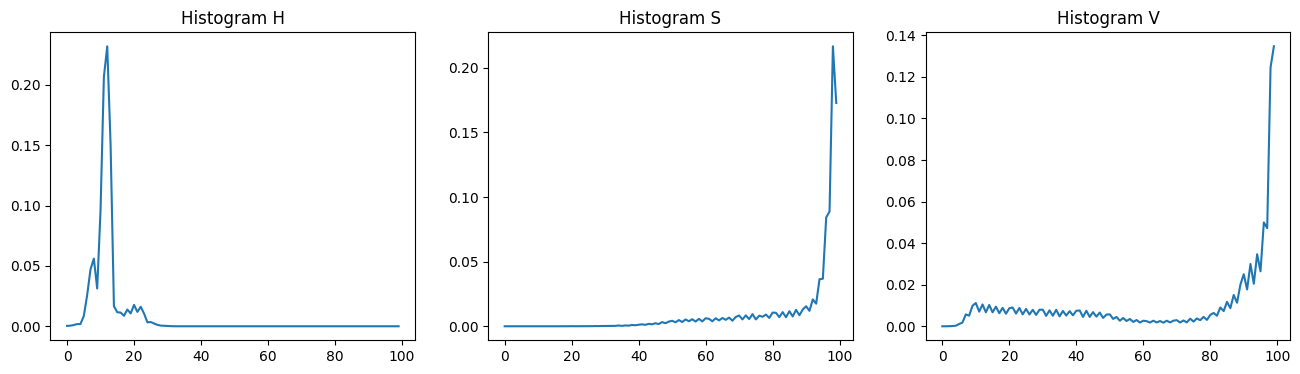

In [13]:
# prevod do HSV
img_template_hsv = cv2.cvtColor(img_template, cv2.COLOR_RGB2HSV)
H, S, V = cv2.split(img_template_hsv)

# vypocet histogramu
HIST_LEN = 100
img_template_hist_H = cv2.calcHist([H], [0], None, [HIST_LEN], [0, 180])
img_template_hist_S = cv2.calcHist([S], [0], None, [HIST_LEN], [0, 255])
img_template_hist_V = cv2.calcHist([V], [0], None, [HIST_LEN], [0, 255])

# normalizace histogramu
img_template_hist_H = img_template_hist_H / np.sum(img_template_hist_H)
img_template_hist_S = img_template_hist_S / np.sum(img_template_hist_S)
img_template_hist_V = img_template_hist_V / np.sum(img_template_hist_V)

# vizualizace
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(img_template_hist_H)
plt.title("Histogram H")
plt.subplot(1, 3, 2)
plt.plot(img_template_hist_S)
plt.title("Histogram S")
plt.subplot(1, 3, 3)
plt.plot(img_template_hist_V)
plt.title("Histogram V")
plt.show()

## Porovnání histogramu s histogramem vzorového obrázku
- Kullback-Lieblerovy divergence

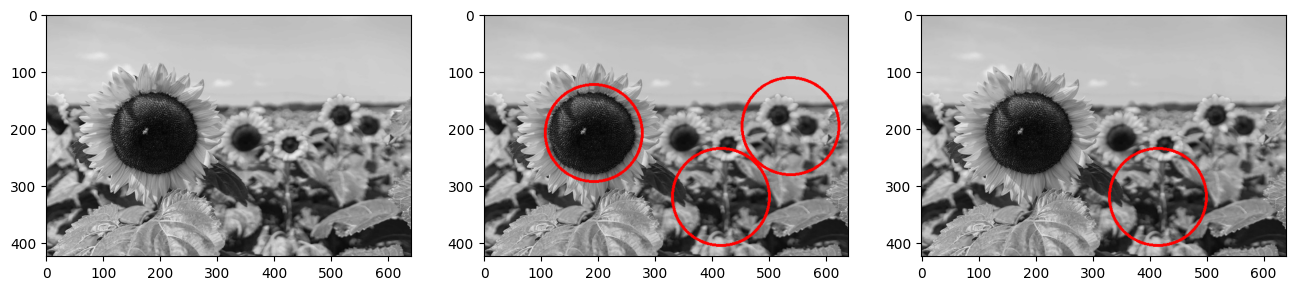

In [14]:
# Kullback-Lieblerovy divergence
import scipy.special

# suma kvadratu odchylek
def sum_of_squares(array1, array2) -> float:
    return np.sum((array1 - array2)**2)

def KL_divergence(hist1, hist2, epsilon=1e-10):
    """
    Calculate Kullback-Liebler divergence between two histograms.
    
    Parameters:
        hist1 (ndarray): First histogram.
        hist2 (ndarray): Second histogram.
        
    Returns:
        float: Kullback-Liebler divergence.
    """
    # normalizace
    hist1 = hist1 / np.sum(hist1)
    hist2 = hist2 / np.sum(hist2)
    kl_div = hist1 * np.log((hist1 + epsilon) / (hist2 + epsilon))
    return np.sum(kl_div)

def compare_blob_and_etalon(img, blob:tuple, etalon_H:np.ndarray) -> float:
    """
    Compare blob with etalon.
    
    Parameters:
        img (ndarray): Input image.
        blob (tuple): Blob (x, y, r).
        etalon_H (ndarray): Etalon histogram.
    
    Returns:
        float: sum(Kullback-Liebler divergence)
    """
    box = convert_blob_to_box(blob)
    x1, y1 = box[0]
    x2, y2 = box[1]
    img_blob = img[y1:y2, x1:x2]
    #print(img_blob.shape)
    img_blob_hsv = cv2.cvtColor(img_blob, cv2.COLOR_RGB2HSV)
    H, _, _ = cv2.split(img_blob_hsv)
    hist_H = cv2.calcHist([H], [0], None, [HIST_LEN], [0, 180])
    return KL_divergence(hist_H, etalon_H)
    #return np.sum(scipy.special.kl_div(hist_H, etalon_H))

def remove_unfiting_blobs_with_KL_div(img, blobs, img_template_hist_H, divergence_threshold:float=1) -> tuple:
    """ 
    Remove blobs with divergence higher than divergence_threshold.
    """
    blobs_filtered = []
    for blob in blobs:
        divergence = compare_blob_and_etalon(img, blob, img_template_hist_H)
        if DEBUG:
            print(divergence)
        if divergence < divergence_threshold:
            blobs_filtered.append(blob)
    return blobs_filtered

# test

# Draw blobs
img_blobs = img_gray.copy()
img_filtered_blobs = img_gray.copy()
# to color
img_blobs = cv2.cvtColor(img_blobs, cv2.COLOR_GRAY2RGB)
img_filtered_blobs = cv2.cvtColor(img_filtered_blobs, cv2.COLOR_GRAY2RGB)
color = (255, 0, 0)
radius = 3

# Draw blobs
for x, y, sigma in blobs:
    r = sigma_to_radius(sigma)
    cv2.circle(img_blobs, (x, y), r, color, radius)

# Filter blobs
divergence_threshold = 1.2
blobs_filtered = remove_unfiting_blobs_with_KL_div(imgs[0], blobs, img_template_hist_H, divergence_threshold)

# Draw filtered blobs
for x, y, sigma in blobs_filtered:
    r = sigma_to_radius(sigma)
    cv2.circle(img_filtered_blobs, (x, y), r, color, radius)

# visualize
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(img_blobs)
plt.subplot(1, 3, 3)
plt.imshow(img_filtered_blobs)

plt.show()

## Area of Overlapping Rectangles
The area of any rectangle can be calculated using the formula: (x_distance) * (y_distance). Since the rectangles may overlap, we can use Inclusion Exclusion principle to calculate the area as follows:


Total Area = Area of Rectangle1 + Area of Rectangle2 – Intersecting area of both the rectangles 


For Rectangle1:
```Python
x_distance = abs(L1.x – R1.x) 
y_distance = abs(L1.y – R1.y) 
Area of Rectangle1 = x_distance * y_distance
```

For Rectangle2:
```Python
x_distance = abs(L2.x – R2.x) 
y_distance = abs(L2.y – R2.y)
Area of Rectangle2 = x_distance * y_distance
```

For area of overlapping Rectangle:
```Python
x_distance = min(R1.x, R2.x) – max(L1.x, L2.x) 
y_distance = min(R1.y, R2.y) – max(L1.y, L2.y)
Area of overlapping rectange = x_distance * y_distance
```
If the x_distance or y_distance is negative, then the two rectangles do not intersect. In that case, overlapping area is 0.

## Precision and Recall

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

where:
- TP = True Positive
- FP = False Positive
- FN = False Negative


## Test run

Number of sigmas: 10
Number of layers: 10
Number of maxima: 205
Drawin 205 of boxes.
Stats:
 - Precision: 0.86
 - Recall: 0.03
(424, 640, 3)


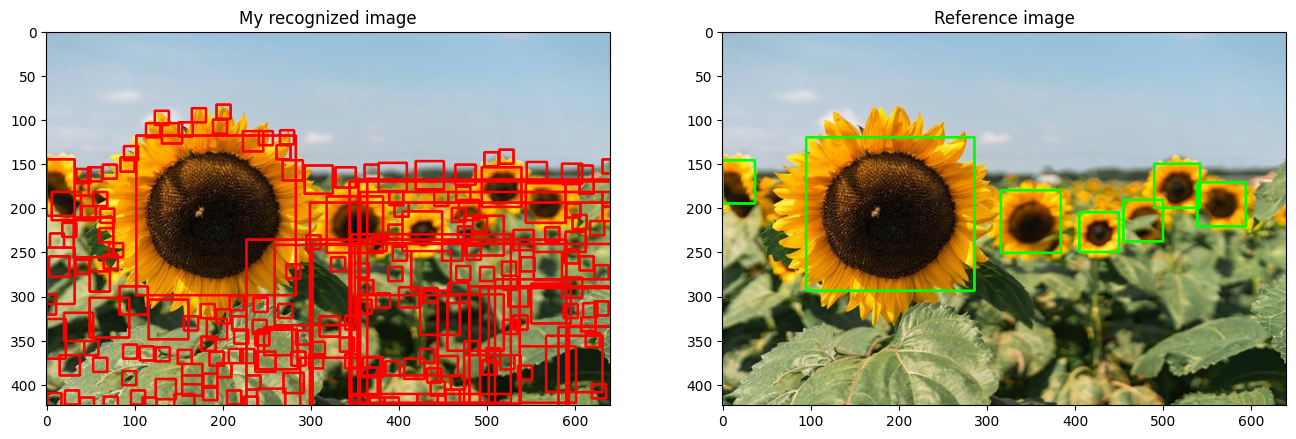

In [15]:
VERBOSE = True
# ploting
recognition_color = (255, 0, 0)
reference_color = (0, 255, 0)
thickness = 2

# sigma range
sigma_min = 4
min_distance = int(10)

# blobing
divergence_threshold = 0.5
divergence_threshold = 0.6

# load first file and visualize
for image, text_file in zip(imgs, files):

    # draw reference boxes 
    referece_img = image.copy()
    for box_coord in dict_files_boxes[text_file]:
        x1, y1 = box_coord[0]
        x2, y2 = box_coord[1]
        cv2.rectangle(referece_img, (x1, y1), (x2, y2), reference_color, thickness)
    
    # recognition
    blobs = []
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sigma_max = int(min(image.shape[0], image.shape[1])/4)
    sigmas = list(genereta_sizes(sigma_min, sigma_max))
    # np.array of LoGs of image
    img_logs = []
    for sigma in sigmas:
        img_logs.append(LoG_filter(img_gray, sigma))

    # array to np.array
    img_logs = np.stack(img_logs, axis=-1)

    # Find local maxima
    maxima = skimage.feature.peak_local_max(img_logs, min_distance=min_distance, exclude_border=False)

    if VERBOSE:
        num_sigmas = len(sigmas)
        print("Number of sigmas:", num_sigmas)
        print("Number of layers:", img_logs.shape[-1])
        print("Number of maxima:", len(maxima))

    # Create list of blobs
    for y, x, z in maxima:
        blobs.append((x, y, sigmas[z]))
        
    blobs_filtered = remove_unfiting_blobs_with_KL_div(image, blobs, img_template_hist_H, divergence_threshold)
    blobs_filtered = blobs

    # draw recognized boxes
    recognized_img = image.copy()
    recognized_boxes = []
    print("Drawin", len(blobs_filtered) ,"of boxes.")
    for blob in blobs_filtered:
        box = convert_blob_to_box(blob)
        recognized_boxes.append(box)
        x1, y1 = box[0]
        x2, y2 = box[1]
        cv2.rectangle(recognized_img, (x1, y1), (x2, y2), recognition_color, thickness)
    
    # calculate stats
    precision, recall = precision_recall(recognized_boxes, dict_files_boxes[text_file])

    # print stats
    print("Stats:")
    print(" - Precision:", float(round(precision, 2)))
    print(" - Recall:", float(round(recall, 2)))

    # plot pictures
    print(image.shape)
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(recognized_img)
    plt.title("My recognized image")
    plt.subplot(1, 2, 2)
    plt.imshow(referece_img)
    plt.title("Reference image")
    break

## Vykreslení na všech obrázcích

Drawin 14 of boxes.
Stats:
 - Precision: 0.86
 - Recall: 0.43

Drawin 33 of boxes.
Stats:
 - Precision: 0.7
 - Recall: 0.64

Drawin 18 of boxes.
Stats:
 - Precision: 0.54
 - Recall: 0.72

Drawin 7 of boxes.
Stats:
 - Precision: 0.62
 - Recall: 0.71



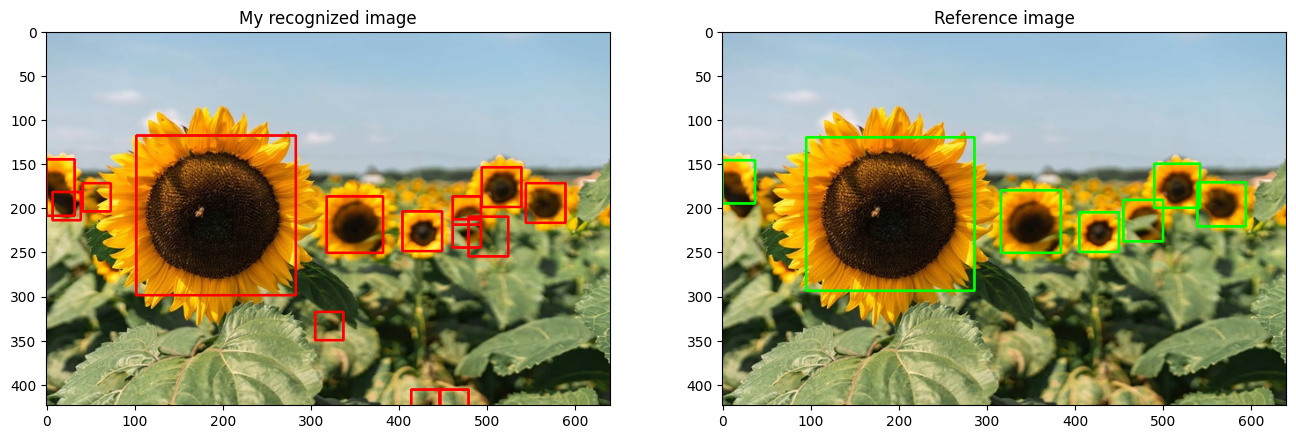

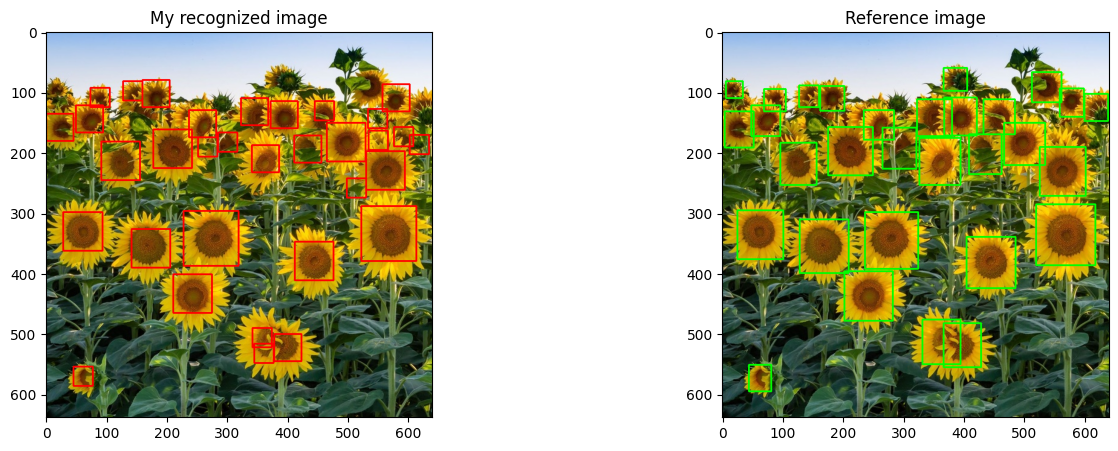

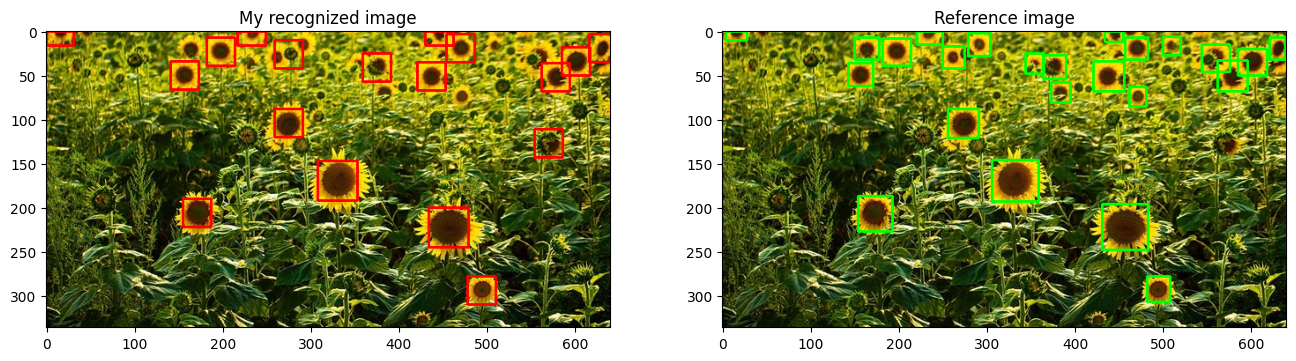

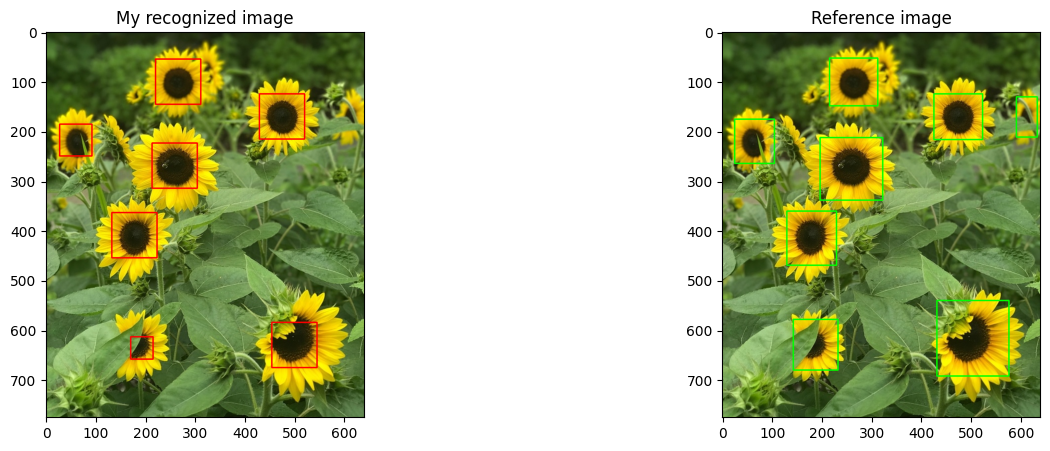

In [27]:
VERBOSE = False
# ploting
recognition_color = (255, 0, 0)
reference_color = (0, 255, 0)
thickness = 2

# sigma range
sigma_min = 8
min_distance = 20

# blobing
divergence_threshold = 0.5
divergence_threshold = 1.1

# load first file and visualize
for image, text_file in zip(imgs, files):

    # draw reference boxes 
    referece_img = image.copy()
    for box_coord in dict_files_boxes[text_file]:
        x1, y1 = box_coord[0]
        x2, y2 = box_coord[1]
        cv2.rectangle(referece_img, (x1, y1), (x2, y2), reference_color, thickness)
    
    # recognition
    blobs = []
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sigma_max = int(min(image.shape[0], image.shape[1])/4)
    sigmas = list(genereta_sizes(sigma_min, sigma_max))
    # np.array of LoGs of image
    img_logs = []
    for sigma in sigmas:
        img_logs.append(LoG_filter(img_gray, sigma))

    # array to np.array
    img_logs = np.stack(img_logs, axis=-1)

    # Find local maxima
    maxima = skimage.feature.peak_local_max(img_logs, min_distance=min_distance, exclude_border=False)

    if VERBOSE:
        num_sigmas = len(sigmas)
        print("Number of sigmas:", num_sigmas)
        print("Number of layers:", img_logs.shape[-1])
        print("Number of maxima:", len(maxima))

    # Create list of blobs
    for y, x, z in maxima:
        blobs.append((x, y, sigmas[z]))
        
    blobs_filtered = remove_unfiting_blobs_with_KL_div(image, blobs, img_template_hist_H, divergence_threshold)
    #blobs_filtered = blobs

    # draw recognized boxes
    recognized_img = image.copy()
    recognized_boxes = []
    print("Drawin", len(blobs_filtered) ,"of boxes.")
    for blob in blobs_filtered:
        box = convert_blob_to_box(blob)
        recognized_boxes.append(box)
        x1, y1 = box[0]
        x2, y2 = box[1]
        cv2.rectangle(recognized_img, (x1, y1), (x2, y2), recognition_color, thickness)
    
    # calculate stats
    precision, recall = precision_recall(recognized_boxes, dict_files_boxes[text_file])

    # print stats
    print(Green + "Stats:" + NC)
    print(" - Precision: " + Blue + str(float(round(precision, 2))) + NC)
    print(" - Recall: " + Blue + str(float(round(recall, 2))) + NC)
    print()

    # plot pictures
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(recognized_img)
    plt.title("My recognized image")
    plt.subplot(1, 2, 2)
    plt.imshow(referece_img)
    plt.title("Reference image")